# Taxi-week 3.
## Прогнозирование ряда со сложной сезонностью

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import datetime

In [2]:
import warnings
warnings.simplefilter(action='ignore')

## Загрузка данных
Загрузите все подготовленные данные о количестве поездок в Желтом такси и объедините в один датасет все, кроме данных за последний имеющийся месяц — июнь 2016.

In [3]:
df_6=pd.read_csv("taxi_2016_06.csv", index_col=0)
df_5=pd.read_csv("taxi_2016_05.csv", index_col=0)
df_3=pd.read_csv("taxi_2016_03.csv", index_col=0)
df_4=pd.read_csv("taxi_2016_04.csv", index_col=0)
df_2=pd.read_csv("taxi_2016_02.csv", index_col=0)
df_1=pd.read_csv("taxi_2016_01.csv", index_col=0)

In [4]:
df=pd.concat([ df_1,df_2,df_3,df_4,df_5], axis=0)

In [5]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.shape

(3648, 2500)

###  Задание 1





In [7]:
# Координаты прямоугольника Нью-Йорка
West=-74.25559
East=-73.70001
South=40.49612
North=40.91553

In [8]:
def get_single_reg_num(v, step=50, W=West, E=East, S=South, N=North):
    step_long = (E - W)/step
    step_lat = (N - S)/step
    num_long = np.floor((v[0] - W)/step_long) 
    num_lat = np.floor((v[1] - S)/step_lat) 
    reg = num_long*step + num_lat + 1
    return reg

In [9]:
c1 = 40.782500
c2 = -73.965493
park = get_single_reg_num([c2, c1])

In [10]:
park

1335.0

In [11]:
# Ваш кода  - создание датасета
reg_num = int(park)
my_data = pd.DataFrame(df.iloc[:, reg_num])
my_data

,1336
2016-01-01 00:00:00,109.0
2016-01-01 01:00:00,131.0
2016-01-01 02:00:00,88.0
2016-01-01 03:00:00,54.0
2016-01-01 04:00:00,22.0
...,...
2016-05-31 19:00:00,84.0
2016-05-31 20:00:00,63.0
2016-05-31 21:00:00,54.0
2016-05-31 22:00:00,22.0


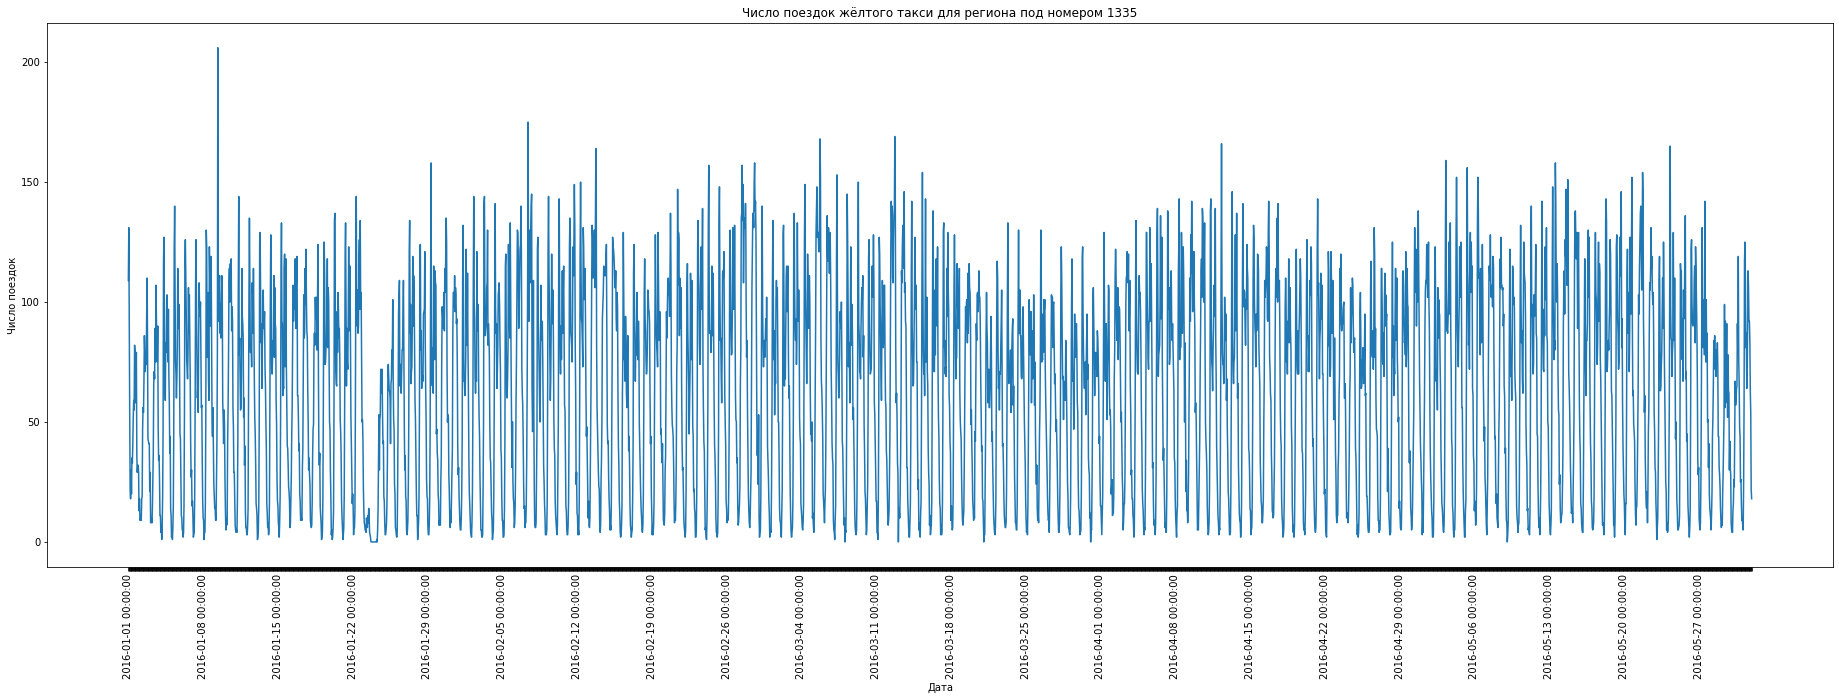

In [12]:
# Ваш код- построение графика
plt.figure(figsize=(32,10))
plt.plot(my_data[str(reg_num + 1)], color='tab:blue')
plt.xticks(rotation=90)
n = 24*7
ax = plt.gca()
[l.set_visible(False) for (i, l) in enumerate (ax.xaxis.get_ticklabels()) if i % n != 0 ]

plt.gca().set(title=f"Число поездок жёлтого такси для региона под номером {str(reg_num)}", xlabel="Дата", ylabel="Число поездок")
plt.show()

### Задание 2


<Figure size 720x504 with 0 Axes>

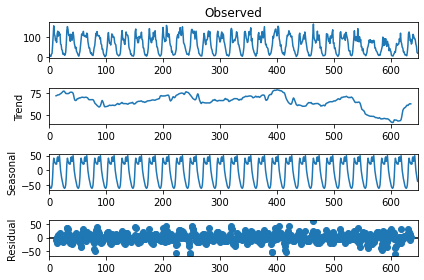

In [13]:
# Ваш код
plt.figure(figsize=(10, 7))
sm.tsa.seasonal_decompose(my_data[str(reg_num + 1)].values[3000:3648], period=24).plot()
plt.show()

In [14]:
print(f'Дики-Фулер p-values {adfuller(my_data[str(reg_num + 1)].values)[1]}')

Дики-Фулер p-values 2.4013707029426727e-08


## Конструирование признаков

### Задание 3



In [15]:
np.arange(len(my_data[str(reg_num + 1)]))

array([   0,    1,    2, ..., 3645, 3646, 3647])

In [16]:
# Ваш код
def add_component(data, n=5, w=168):
    t = np.arange(len(data[str(reg_num + 1)]))
    data['b'] = np.ones(len(data[str(reg_num + 1)]))
    
    for i in range(n):
        cos = 'c' + str(i+1)
        sin = 's' + str(i+1)
        data[cos] =np.cos(2*np.pi*i*t/w)
        data[sin] =np.sin(2*np.pi*i*t/w)
    return data
        

In [17]:
my_data = add_component(my_data, 50)

In [18]:
my_data

,1336,b,c1,s1,c2,s2,c3,s3,c4,s4,...,c46,s46,c47,s47,c48,s48,c49,s49,c50,s50
2016-01-01 00:00:00,109.0,1.0,1.0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000
2016-01-01 01:00:00,131.0,1.0,1.0,0.0,0.999301,0.037391,0.997204,0.074730,0.993712,0.111964,...,-0.111964,0.993712,-0.149042,0.988831,-0.185912,0.982566,-0.222521,9.749279e-01,-0.258819,0.965926
2016-01-01 02:00:00,88.0,1.0,1.0,0.0,0.997204,0.074730,0.988831,0.149042,0.974928,0.222521,...,-0.974928,-0.222521,-0.955573,-0.294755,-0.930874,-0.365341,-0.900969,-4.338837e-01,-0.866025,-0.500000
2016-01-01 03:00:00,54.0,1.0,1.0,0.0,0.993712,0.111964,0.974928,0.222521,0.943883,0.330279,...,0.330279,-0.943883,0.433884,-0.900969,0.532032,-0.846724,0.623490,-7.818315e-01,0.707107,-0.707107
2016-01-01 04:00:00,22.0,1.0,1.0,0.0,0.988831,0.149042,0.955573,0.294755,0.900969,0.433884,...,0.900969,0.433884,0.826239,0.563320,0.733052,0.680173,0.623490,7.818315e-01,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,84.0,1.0,1.0,0.0,-0.399892,-0.916562,-0.680173,0.733052,0.943883,0.330279,...,0.330279,-0.943883,-0.997204,0.074730,0.467269,0.884115,0.623490,-7.818315e-01,-0.965926,-0.258819
2016-05-31 20:00:00,63.0,1.0,1.0,0.0,-0.365341,-0.930874,-0.733052,0.680173,0.900969,0.433884,...,0.900969,0.433884,0.074730,-0.997204,-0.955573,0.294755,0.623490,7.818315e-01,0.500000,-0.866025
2016-05-31 21:00:00,54.0,1.0,1.0,0.0,-0.330279,-0.943883,-0.781831,0.623490,0.846724,0.532032,...,-0.532032,0.846724,0.974928,0.222521,-0.111964,-0.993712,-0.900969,4.338837e-01,0.707107,0.707107
2016-05-31 22:00:00,22.0,1.0,1.0,0.0,-0.294755,-0.955573,-0.826239,0.563320,0.781831,0.623490,...,-0.781831,-0.623490,-0.365341,0.930874,0.997204,0.074730,-0.222521,-9.749279e-01,-0.866025,0.500000


In [19]:
my_data.columns.values[1::]

array(['b', 'c1', 's1', 'c2', 's2', 'c3', 's3', 'c4', 's4', 'c5', 's5',
       'c6', 's6', 'c7', 's7', 'c8', 's8', 'c9', 's9', 'c10', 's10',
       'c11', 's11', 'c12', 's12', 'c13', 's13', 'c14', 's14', 'c15',
       's15', 'c16', 's16', 'c17', 's17', 'c18', 's18', 'c19', 's19',
       'c20', 's20', 'c21', 's21', 'c22', 's22', 'c23', 's23', 'c24',
       's24', 'c25', 's25', 'c26', 's26', 'c27', 's27', 'c28', 's28',
       'c29', 's29', 'c30', 's30', 'c31', 's31', 'c32', 's32', 'c33',
       's33', 'c34', 's34', 'c35', 's35', 'c36', 's36', 'c37', 's37',
       'c38', 's38', 'c39', 's39', 'c40', 's40', 'c41', 's41', 'c42',
       's42', 'c43', 's43', 'c44', 's44', 'c45', 's45', 'c46', 's46',
       'c47', 's47', 'c48', 's48', 'c49', 's49', 'c50', 's50'],
      dtype=object)

In [20]:
model = sm.OLS(my_data[str(reg_num + 1)], my_data[my_data.columns.values[1::]])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   1336   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     248.3
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        16:20:45   Log-Likelihood:                -15014.
No. Observations:                3648   AIC:                         3.023e+04
Df Residuals:                    3549   BIC:                         3.084e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
b             31.5597      0.125    253.454      0.0

###  Задание 4


In [21]:
# Ваш код
pred = results.predict(my_data[my_data.columns.values[1::]])
rem = my_data[str(reg_num + 1)] - pred

In [22]:
rem

2016-01-01 00:00:00     89.890852
2016-01-01 01:00:00    113.843471
2016-01-01 02:00:00     77.961971
2016-01-01 03:00:00     47.903807
2016-01-01 04:00:00     14.142067
                          ...    
2016-05-31 19:00:00      4.011846
2016-05-31 20:00:00      9.144364
2016-05-31 21:00:00     11.199356
2016-05-31 22:00:00    -11.834035
2016-05-31 23:00:00     -0.721901
Length: 3648, dtype: float64

<Figure size 720x504 with 0 Axes>

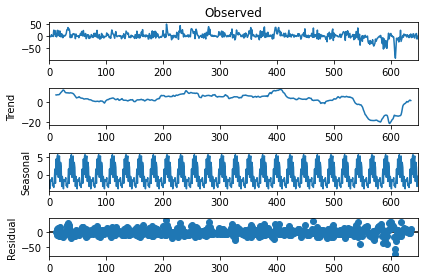

In [23]:
# Ваш код
plt.figure(figsize=(10, 7))
sm.tsa.seasonal_decompose(rem.values[3000:3648], period=24).plot()
plt.show()

In [24]:
print(f'Дики-Фулер p-values {adfuller(rem.values)[1]}')

Дики-Фулер p-values 8.822064904484391e-10


In [25]:
rem_24 = rem - rem.shift(24)

In [26]:
rem_24

2016-01-01 00:00:00          NaN
2016-01-01 01:00:00          NaN
2016-01-01 02:00:00          NaN
2016-01-01 03:00:00          NaN
2016-01-01 04:00:00          NaN
                         ...    
2016-05-31 19:00:00    17.483968
2016-05-31 20:00:00    15.710994
2016-05-31 21:00:00     7.899779
2016-05-31 22:00:00    -7.745948
2016-05-31 23:00:00    -9.966877
Length: 3648, dtype: float64

<Figure size 720x504 with 0 Axes>

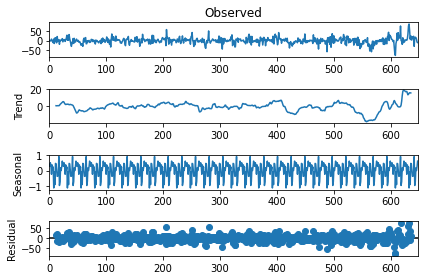

In [27]:
# Ваш код
plt.figure(figsize=(10, 7))
sm.tsa.seasonal_decompose(rem_24.values[3000:3648], period=24).plot()
plt.show()

##  Подбор параметров моделей SARMA и SARIMA



###  Задание 5


##  Обучение моделей и проверка качества прогноза  

In [28]:
def sarimax_gridsearch(ts, exog, par, d=0, D=0, s=24, maxiter=50, freq='H'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for comb in par:
        try:
            #print("ahahah")
            model = sm.tsa.statespace.SARIMAX(ts, exog,
                                                order=(comb[0],d,comb[1]),
                                                seasonal_order=(comb[2],D, comb[3],s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
            #print("ohoho")
            output = model.fit(maxiter=maxiter, method='nm', disp=-1)#, low_memory=True) 
            #print("sg")
            ans.append([comb,output.aic])
            print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
            
    # Find the parameters with minimal AIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pqPQ', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:10]
    
    return ans_df

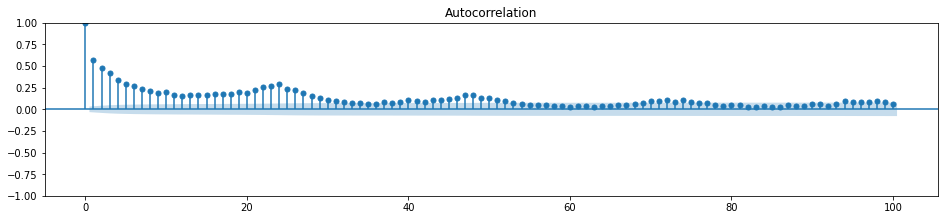

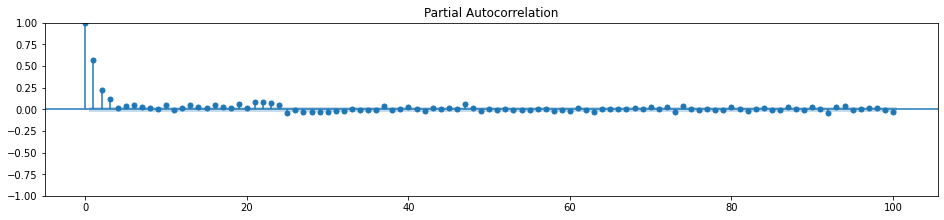

In [29]:
plt.figure(figsize=(16, 7)) 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(rem.values.squeeze(), lags=100, ax=ax)
plt.show()
plt.figure(figsize=(16, 7)) 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(rem.values.squeeze(), lags=100, ax=ax)
plt.show()

In [30]:
time_series = my_data[str(reg_num + 1)]

In [31]:
# 
Q = range(0, 1)
q = range(0, 12)
P = range(0, 1)
p = range(0, 3)
D=0
d=0
s=24
ex= my_data[my_data.columns.values[1::]]

In [32]:
from itertools import product
parameters = list(product(p, q, P, Q))
len(parameters)

36

In [ ]:
%%time
sarimax_gridsearch(time_series, ex, parameters, freq='H')

###  Задание 6


In [33]:
p=1
P=0
Q=0
q=11
D=0
d=0
s=24
#ex=...
mod = sm.tsa.statespace.SARIMAX(time_series, exog=ex, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)

In [34]:
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                   1336   No. Observations:                 3648
Model:              SARIMAX(1, 0, 11)   Log Likelihood              -13985.532
Date:                Mon, 09 May 2022   AIC                          28199.064
Time:                        16:22:12   BIC                          28905.709
Sample:                    01-01-2016   HQIC                         28450.769
                         - 05-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b             31.5879      1.187     26.620      0.000      29.262      33.914
c1            31.5879      1.187     26.620      0.000      29.262      33.914
s1         -3.982e-15   1.17e-11     -0.000      1.0

In [35]:
time_series.index[0]

'2016-01-01 00:00:00'

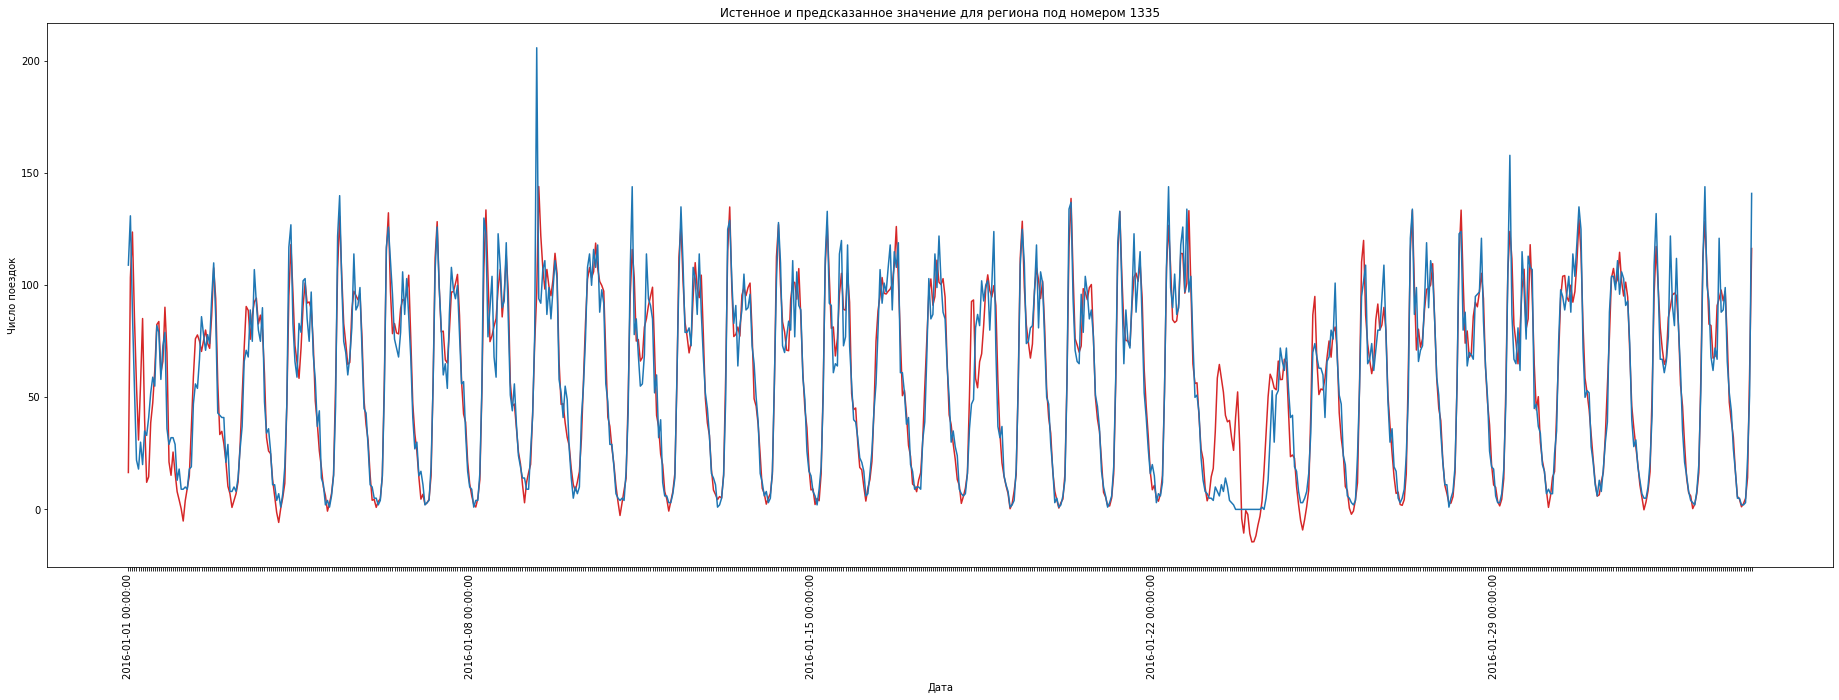

In [46]:
#time_series = my_data[str(reg_num + 1)][3000:3648]

pred_time_series = mod.predict(start='2016-01-01 00:00:00',
                               end='2016-05-31 23:00:00', dynamic=False, exog=ex).values

plt.figure(figsize=(32,10))
plt.plot(pred_time_series[0:800], color='tab:red')
plt.plot(time_series[0:800], color='tab:blue')



plt.xticks(rotation=90)
n = 24*7
ax = plt.gca()
[l.set_visible(False) for (i, l) in enumerate (ax.xaxis.get_ticklabels()) if i % n != 0 ]

plt.gca().set(title=f"Истенное и предсказанное значение для региона под номером {str(reg_num)}", xlabel="Дата", ylabel="Число поездок")
plt.show()

In [37]:
# импортируете функций вычисления регрессионных метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score  

In [47]:
# Ваш код - вычисление метрик
print(f' средний квадрат ошибки {mean_squared_error(pred_time_series, time_series.values)}')
print(f' средняя абсолютная ошибка {mean_absolute_error(pred_time_series, time_series.values)}')
print(f' средняя абсолютная процентная ошибка {mean_absolute_percentage_error(pred_time_series, time_series.values)}')
print(f' r2 {r2_score(pred_time_series, time_series.values)}')

 средний квадрат ошибки 133.18480916572582
 средняя абсолютная ошибка 8.16218743319441
 средняя абсолютная процентная ошибка 0.27014817559748866
 r2 0.9167061187991943


## Прогнозирование на новых данных

###  Задание 7



In [39]:
# Ваш код - создание датасета
df=pd.concat([ df_1,df_2,df_3,df_4,df_5, df_6], axis=0)

In [40]:
my_data = pd.DataFrame(df.iloc[:, reg_num])
my_data

,1336
2016-01-01 00:00:00,109.0
2016-01-01 01:00:00,131.0
2016-01-01 02:00:00,88.0
2016-01-01 03:00:00,54.0
2016-01-01 04:00:00,22.0
...,...
2016-06-30 19:00:00,57.0
2016-06-30 20:00:00,59.0
2016-06-30 21:00:00,37.0
2016-06-30 22:00:00,31.0


In [41]:
my_data = add_component(my_data, 50)

In [42]:
ex= my_data[my_data.columns.values[1::]]

In [60]:
time_series = my_data[str(reg_num + 1)]
mod = sm.tsa.statespace.SARIMAX(time_series, exog=ex, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)

In [69]:
predict=mod.predict(start=datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         end=datetime.datetime.strptime("2016-06-30 23:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         dynamic=False,  exog=ex)

#predict_conf_int = predict.conf_int() # доверительные интервалы для прогнозов
#ci=predict_conf_int.loc['2016-01-01':,]

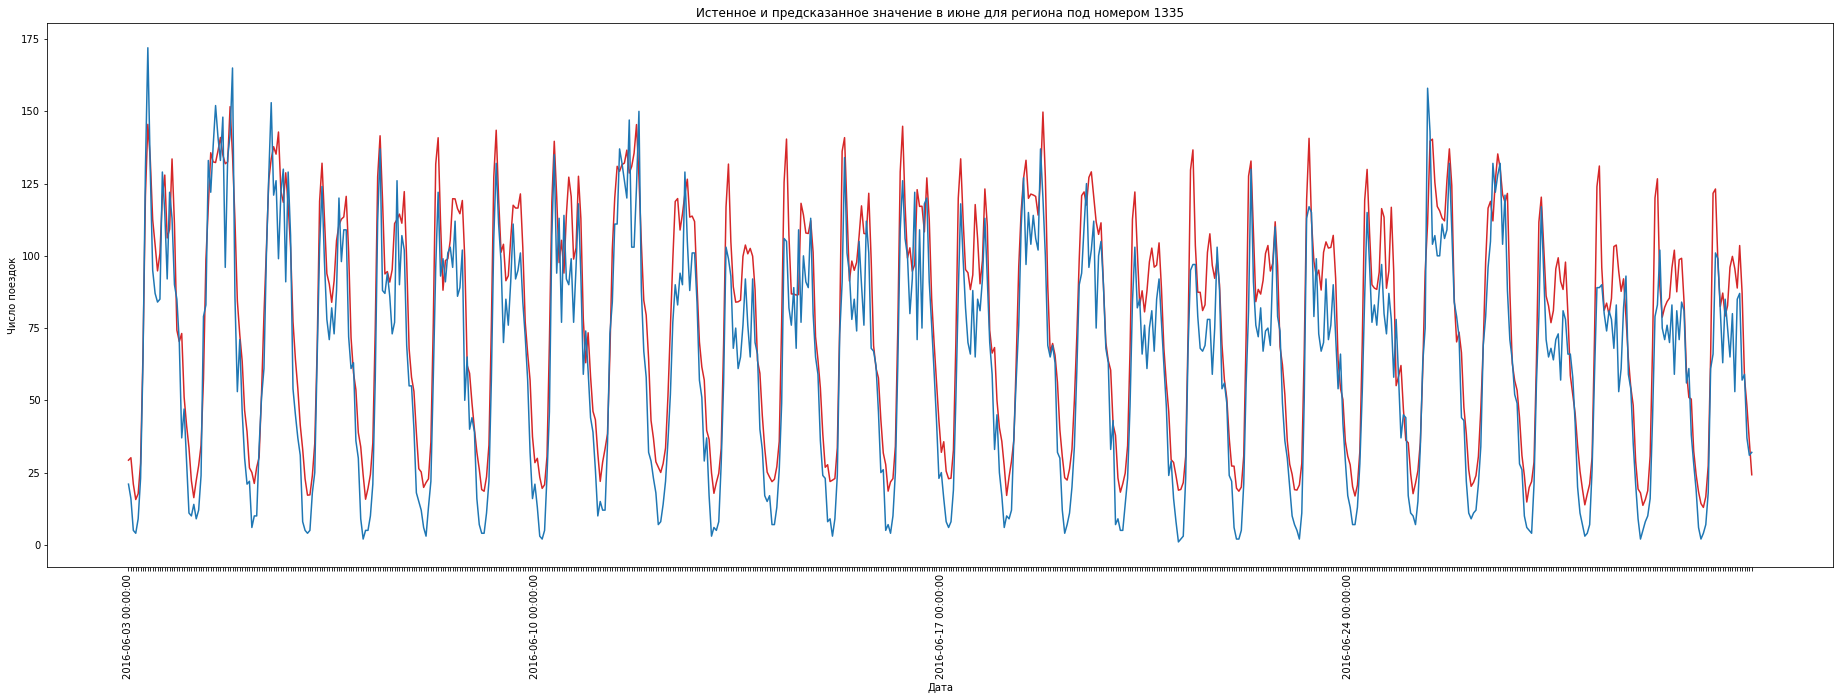

In [72]:
# Ваш код - построение графика
#time_series = my_data[str(reg_num + 1)][3000:3648]



plt.figure(figsize=(32,10))
plt.plot(predict.values[(-168)*4:], color='tab:red')
plt.plot(time_series[(-168)*4:], color='tab:blue')
#plt.plot(ci)



plt.xticks(rotation=90)
n = 24*7
ax = plt.gca()
[l.set_visible(False) for (i, l) in enumerate (ax.xaxis.get_ticklabels()) if i % n != 0 ]

plt.gca().set(title=f"Истенное и предсказанное значение в июне для региона под номером {str(reg_num)}", xlabel="Дата", ylabel="Число поездок")
plt.show()

In [74]:

print(f' средний квадрат ошибки {mean_squared_error(predict.values, time_series.values)}')
print(f' средняя абсолютная ошибка {mean_absolute_error(predict.values, time_series.values)}')
print(f' средняя абсолютная процентная ошибка {mean_absolute_percentage_error(predict.values, time_series.values)}')
print(f' r2 {r2_score(predict.values, time_series.values)}')

 средний квадрат ошибки 223.23769229165222
 средняя абсолютная ошибка 11.687130385143366
 средняя абсолютная процентная ошибка 0.5344025931655064
 r2 0.863715661428009


## Выводы
###  Задание 8 


Визульно грифики прогноза и рельных значений совпадают. Абсолютная ошибка составляет 11.7. В местах, где в исходных данных есть аномалии, к примеру в январе, прозноз даёт некоректный(отрицательный) результат 
